In [1]:
import pandas as pd
from scipy.stats import randint as sp_randint

# Data mung
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import xgboost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Ploting

from matplotlib.pylab import plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
from tune import fitting_model,Random_search,Grid_search\
,plot_test_auc,test_accuracy,report,feature_plot

### 导入数据

In [3]:
jdta = pd.read_csv('./Data/jdata_train.csv',encoding='UTF-8')

### 数据基本信息

In [4]:
jdta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238122 entries, 0 to 238121
Data columns (total 26 columns):
sku_id              238122 non-null int64
attr1               238122 non-null float64
attr2               238122 non-null float64
attr3               238122 non-null float64
cate                238122 non-null int64
brand               238122 non-null int64
dt                  238122 non-null object
comment_num         238122 non-null float64
has_bad_comment     238122 non-null float64
bad_comment_rate    238122 non-null float64
user_id             238122 non-null int64
type_1              238122 non-null float64
type_2              238122 non-null float64
type_3              238122 non-null float64
type_4              238122 non-null float64
type_5              238122 non-null float64
type_6              238122 non-null float64
time                238122 non-null object
model_id            238122 non-null float64
day                 238122 non-null object
age                 

In [5]:
jdta['label'].value_counts()

0.0    237672
1.0       450
Name: label, dtype: int64

In [6]:
jdta.columns

Index(['sku_id', 'attr1', 'attr2', 'attr3', 'cate', 'brand', 'dt',
       'comment_num', 'has_bad_comment', 'bad_comment_rate', 'user_id',
       'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'time',
       'model_id', 'day', 'age', 'sex', 'user_lv_cd', 'user_reg_dt', 'label',
       'duration'],
      dtype='object')

### 特征工程

In [7]:
pred_var = ['attr1', 'attr2', 'attr3', 'cate', 'brand','comment_num','has_bad_comment', 'bad_comment_rate', 
       'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6','model_id','sex', 'user_lv_cd']

In [8]:
outcome_var = 'label'

In [9]:
train, test = train_test_split(jdta, test_size=0.25, random_state=42)

In [10]:
test['label'].value_counts()

0.0    59430
1.0      101
Name: label, dtype: int64

### 训练模型

In [11]:
lr_model = LogisticRegression(n_jobs=-1)

In [12]:
lr_param_grid = [
    {'penalty': ["l2","l1"],
     'C':[0.1,1,10,100]}
  ]

In [13]:
lr_final_grid = Grid_search(lr_model,
                            data=train,
                            pred_var=pred_var,
                            outcome_var=outcome_var,
                            cv_results=False,
                            param=lr_param_grid,
                            beta = 1
                           )

Accuracy:

Confusin matrix:
[[59410    20]
 [   85    16]]


Precision_score:0.444
Recall_score:0.158
ROC_Score:0.579


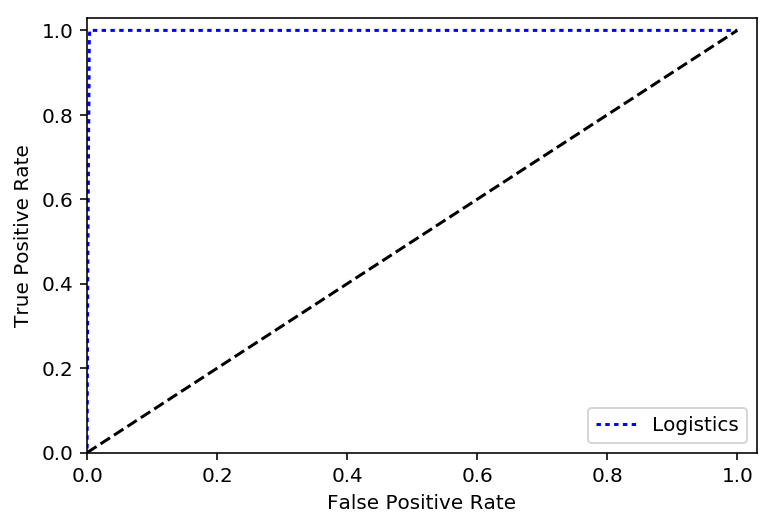

In [14]:
lr_final_grid
test_accuracy(lr_final_grid,test,pred_var,outcome_var)
plot_test_auc(lr_final_grid,test,pred_var,outcome_var,label="Logistics")

<function matplotlib.pyplot.show>

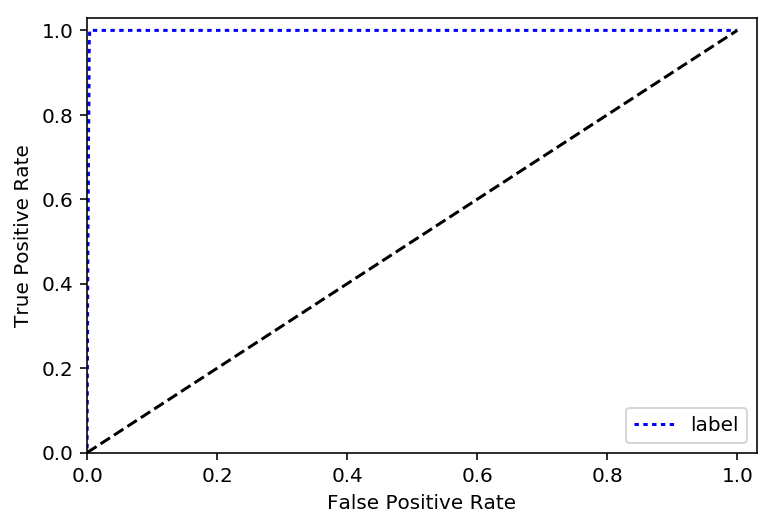

In [32]:
from matplotlib.pylab import plt
y_score = lr_final_grid.predict_proba(test[pred_var])[:,1]
fpr, tpr, thresholds = roc_curve(test[outcome_var],y_score)
plt.plot(fpr,tpr,'b:',label='label')
plt.plot([0,1],[0,1],'k--')
plt.axis([0,1.03,0,1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show

Accuracy:

Confusin matrix:
[[59380    50]
 [   69    32]]


Precision_score:0.390
Recall_score:0.317
ROC_Score:0.658


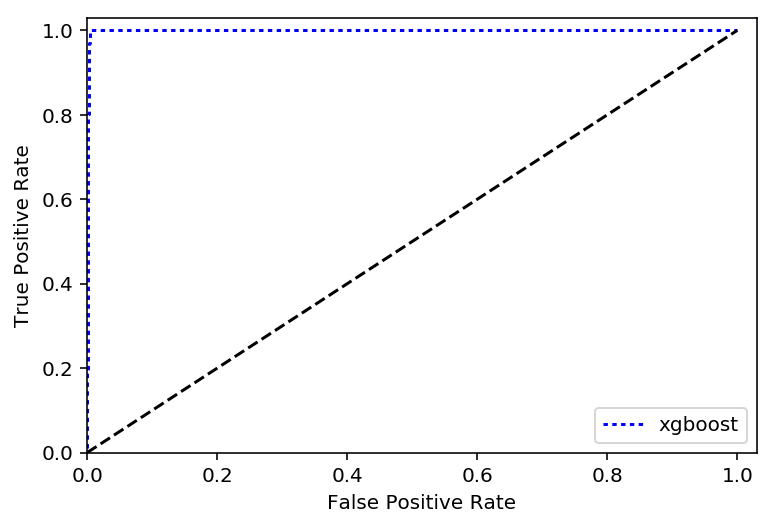

In [35]:
xgboost_model = xgboost.XGBClassifier(nthread=-1)
# specify parameters and distributions to sample from

param_dist = {"n_estimators":[50],
              "max_depth": [20],
              "learning_rate": [0.1],
             "min_child_weight":[1,2,3]}

xgboost_final_grid = Grid_search(model = xgboost_model,
                                 data = train,\
                                 pred_var=pred_var,\
                                 outcome_var= outcome_var,\
                                 param=param_dist
                             )
test_accuracy(xgboost_final_grid,test,pred_var,outcome_var)
plot_test_auc(xgboost_final_grid,test,pred_var,outcome_var,label='xgboost')

In [36]:
xgboost_final_grid

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

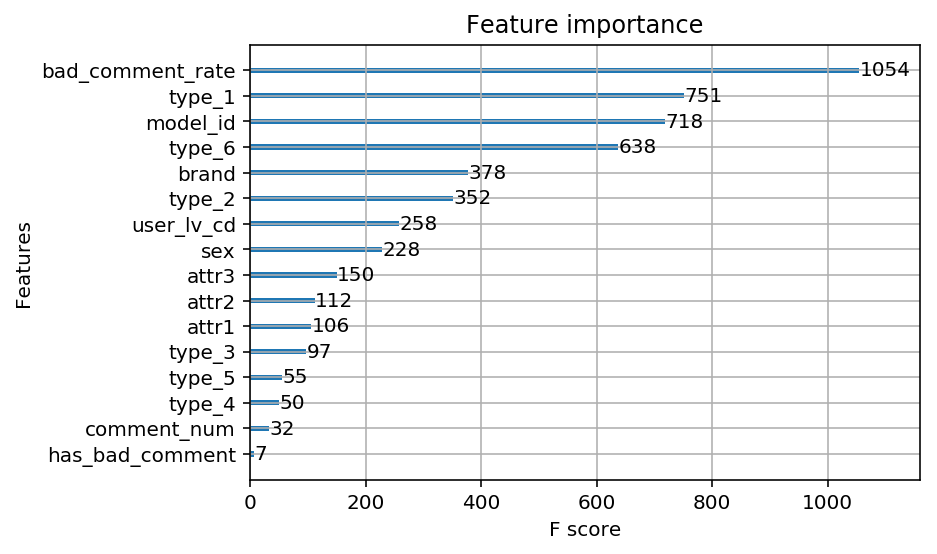

In [37]:
xgboost.plot_importance(xgboost_final_grid)

### 外部测试集预测

In [16]:
jdta_test = pd.read_csv('./Data/jdata_test.csv',encoding='UTF-8')

In [17]:
results = lr_final_grid.predict(jdta_test[pred_var])

In [18]:
results = pd.Series(results).to_frame()
results.columns = ['pred']

In [19]:
results_con = pd.concat([results,jdta_test],axis=1)

In [20]:
r_f = results_con[results_con['pred']==1][['user_id','sku_id']]

In [21]:
r_f = r_f.drop_duplicates('user_id')
r_f.columns=['user_id','sku_id']
r_f.to_csv('submit.csv',index=False)